# データの読み込み

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import argparse

In [19]:
#データのを選択
dataname = "CH_data"

# "wide" or "detail"
data_width = "wide"

# "reguler" or "kfold"
run_mode = "kfold"

if run_mode == "reguler":
    # test or train
    alldata = "test"


In [20]:
log = {}
if data_width == "wide":
    dropout_vals = [0.0, 0.2, 0.4, 0.6]
elif data_width == "detail":
    dropout_vals = [0.3, 0.34, 0.38, 0.42, 0.46]
else:
    print("data_width is wide or detail")
    exit()

# ファイル名のリスト
if run_mode == "reguler":
    filenames = [f"result/dropout/{dataname}_dropout{dropout_val}_predict_{alldata}.txt" for dropout_val in dropout_vals]
elif run_mode == "kfold":
    filenames = [f"result/dropout/{dataname}_CV_dropout{dropout_val}.txt" for dropout_val in dropout_vals]

# 各ファイルからデータを読み込み、データフレームに変換
df_list = [pd.read_csv(filename, sep=" ", header=None) for filename in filenames]

#各データフレームの名称と色
labels = [f"dropout:{dropout_val}" for dropout_val in dropout_vals]
colors = ['red', 'blue', 'green', 'yellow']#, 'purple']

# データフレームを結合
all_df = pd.concat(df_list, axis=1)
all_df["true"] = all_df[0].iloc[:,0]
all_df.drop(0, axis=1, inplace=True)
all_df.columns = *labels, "true"
all_df.head()

# # 抽出した全要素をまとめるdf
# all_df = pd.DataFrame()
# for idx in range(len(df_list[0])):
#     middle_df = pd.DataFrame()
#     for df in df_list:
#         middle_df = pd.concat([middle_df, df.iloc[idx]], axis=1)
#     #middle_dfのindexとcolumnsを入れ替え
#     middle_df = middle_df.T.reset_index(drop=True)
#     # print(middle_df)
#     #middle_dfをall_dfに追加
#     all_df = pd.concat([all_df, middle_df], axis=0)
#     #logに残す
#     max_value = middle_df[1].max()
#     min_value = middle_df[1].min()
#     max_index = middle_df[1].idxmax()
#     min_index = middle_df[1].idxmin()
#     log[f"{middle_df[0][0]}_max:{dropout_vals[max_index]}"] = max_value
#     log[f"{middle_df[0][0]}_min:{dropout_vals[min_index]}"] = min_value
# #all_dfのindexをリセット
# all_df = all_df.reset_index(drop=True)
# all_df

,dropout:0.0,dropout:0.2,dropout:0.4,dropout:0.6,true
0,0.911217,0.823463,0.819628,0.802898,0.925441
1,0.930443,0.945852,0.859181,0.780069,0.885031
2,0.685289,0.573653,0.634391,0.516977,0.532388
3,2.539325,2.340852,2.122921,2.178567,2.356731
4,2.074820,1.937994,1.806965,1.735509,1.946296


# 全体の散布図をplot

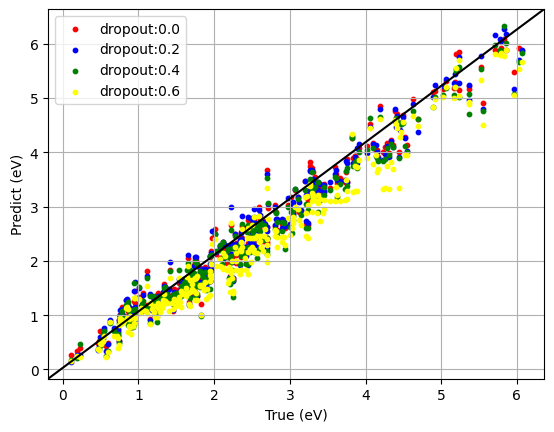

In [26]:
# 散布図を作成します。
plt.figure()
for i, label in enumerate(labels):
    plt.scatter(all_df['true'], all_df[label], color=colors[i], label=label, s=10)

# y=xの直線を描画します。
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='black')

# グリッドを表示します。
plt.grid(True)

# 軸ラベルを設定します。
plt.xlabel('True (eV)')
plt.ylabel('Predict (eV)')

# 凡例を表示します。
plt.legend()

#グラフを保存します。
plt.savefig(f"resultplot/dropout{data_width}_{run_mode}_scatter.png")
# グラフを表示します。
plt.show()

# モデルごとに残差をplot

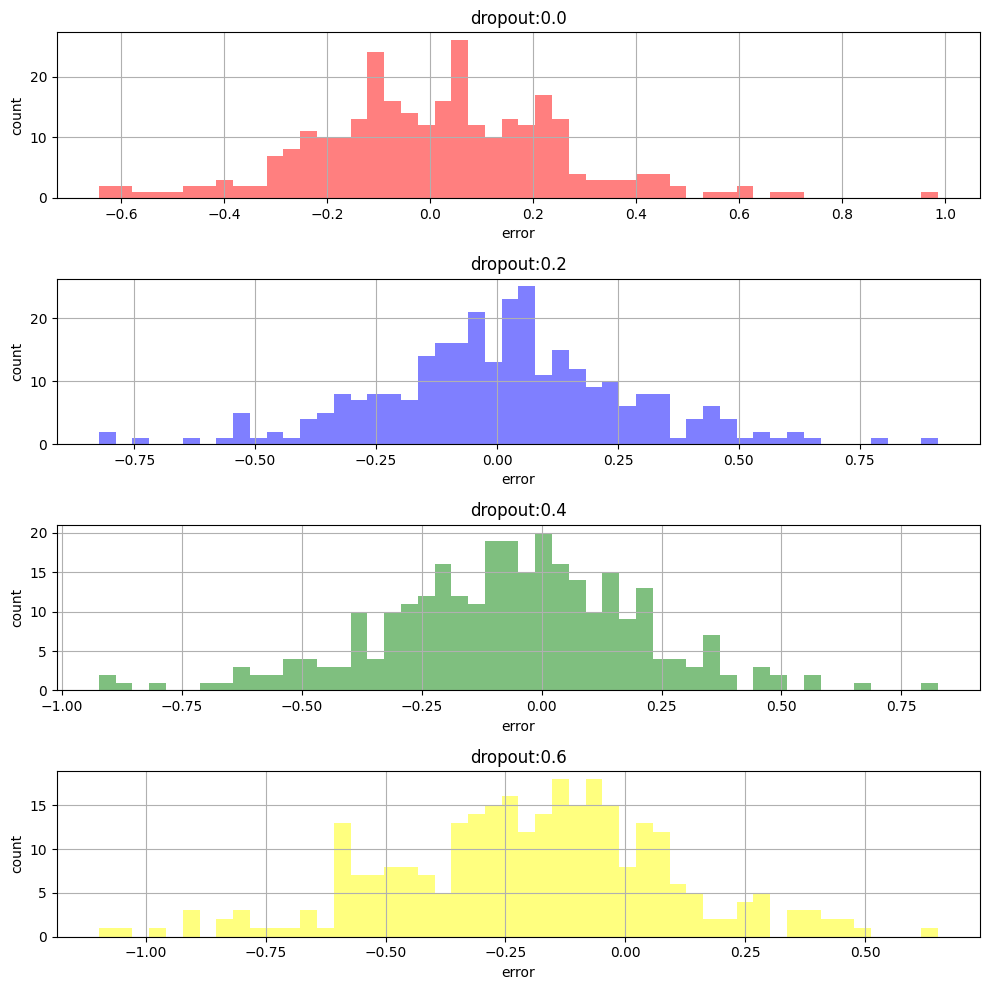

In [27]:
# set len(labels) axs
fig, axs = plt.subplots(len(labels), 1, figsize=(10, 10))
for label in labels:
    (all_df.loc[:,label] - all_df.loc[:,"true"]).plot.hist(ax=axs[labels.index(label)], bins=50, color=colors[labels.index(label)], alpha=0.5)
    axs[labels.index(label)].set_title(label)
    axs[labels.index(label)].set_xlabel("error")
    axs[labels.index(label)].set_ylabel("count")
    axs[labels.index(label)].grid(True)
plt.tight_layout()
plt.show()

# エラーバーの作成

## Max-Minで作成

contain_count: 117
all_count: 292
contain_rate: 0.4006849315068493


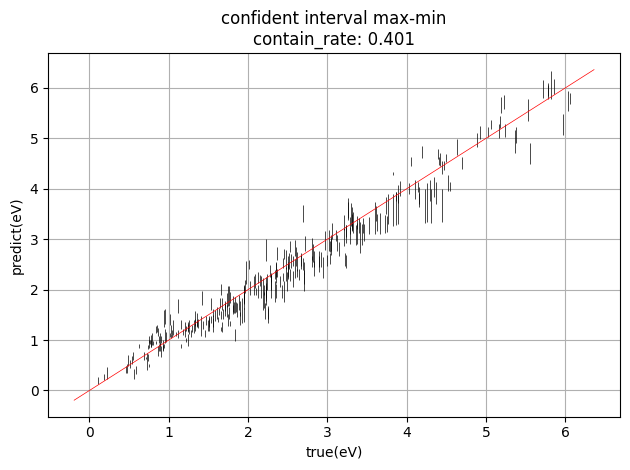

In [28]:
# 各行に対して条件を計算
true_values = all_df.iloc[:, -1]
mean_values = all_df.iloc[:, :-1].mean(axis=1)
std_values = all_df.iloc[:, :-1].std(axis=1)
lower_values = all_df.iloc[:, :-1].min(axis=1)
upper_values = all_df.iloc[:, :-1].max(axis=1)
# 条件に基づいてグラフを描画
plt.vlines(true_values, lower_values, upper_values, color='black', linewidth=0.5)
# 全体のカウント
all_count = len(true_values)
# 条件を満たす場合のカウント
contain_count = np.sum((lower_values <= true_values) & (true_values <= upper_values))

# 結果の出力
print(f"contain_count: {contain_count}")
print(f"all_count: {all_count}")
print(f"contain_rate: {contain_count / all_count}")

# 軸の名前を設定
plt.xlabel('true(eV)')
plt.ylabel('predict(eV)')
# y=xのグラフを描画
x = np.linspace(*plt.xlim())
plt.plot(x, x, color='red', linewidth=0.5)
# グリッドとタイトルを追加
plt.grid(True)
plt.title(f"confident interval max-min\ncontain_rate: {contain_count / all_count:.3f}")
# レイアウトの調整
plt.tight_layout()
# 保存と表示
plt.savefig(f"resultplot/dropout{data_width}.png")
plt.show(block=False)
plt.close()

## 信頼区間を設定してエラーバーを作成
これは各モデルのヒストグラムから残差が正規分布に従うと仮定している。  
平均+-標準偏差で信頼区間68.3%  
平均+-標準偏差*2で信頼区間95.4%  
平均+-標準偏差*3で信頼区間99.7%  

contain_count: 107
all_count: 292
contain_rate: 0.3664383561643836


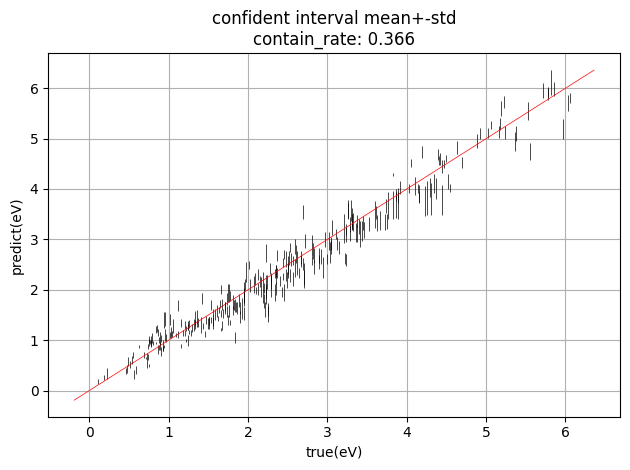

In [29]:
# 各行に対して条件を計算
true_values = all_df.iloc[:, -1]
mean_values = all_df.iloc[:, :-1].mean(axis=1)
std_values = all_df.iloc[:, :-1].std(axis=1)
lower_values = all_df.iloc[:, :-1].mean(axis=1) - all_df.iloc[:, :-1].std(axis=1)
upper_values = all_df.iloc[:, :-1].mean(axis=1) + all_df.iloc[:, :-1].std(axis=1)
# 条件に基づいてグラフを描画
plt.vlines(true_values, lower_values, upper_values, color='black', linewidth=0.5)
# 全体のカウント
all_count = len(true_values)
# 条件を満たす場合のカウント
contain_count = np.sum((lower_values <= true_values) & (true_values <= upper_values))

# 結果の出力
print(f"contain_count: {contain_count}")
print(f"all_count: {all_count}")
print(f"contain_rate: {contain_count / all_count}")

# 軸の名前を設定
plt.xlabel('true(eV)')
plt.ylabel('predict(eV)')
# y=xのグラフを描画
x = np.linspace(*plt.xlim())
plt.plot(x, x, color='red', linewidth=0.5)
# グリッドとタイトルを追加
plt.grid(True)
plt.title(f"confident interval mean+-std\ncontain_rate: {contain_count / all_count:.3f}")
# レイアウトの調整
plt.tight_layout()
# 保存と表示
plt.savefig(f"resultplot/dropout{data_width}.png")
plt.show(block=False)
plt.close()

contain_count: 195
all_count: 292
contain_rate: 0.6678082191780822


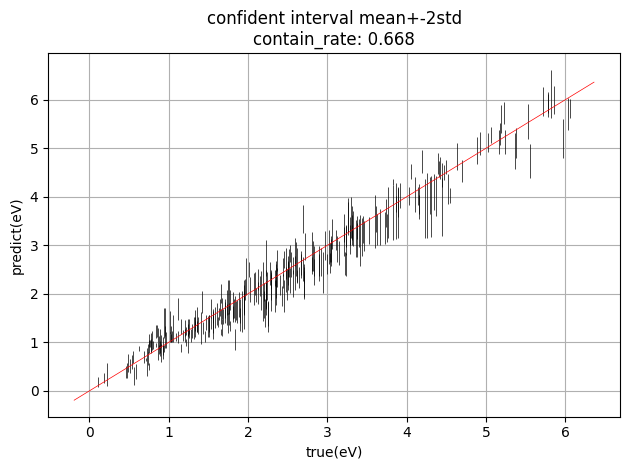

In [30]:
# 各行に対して条件を計算
true_values = all_df.iloc[:, -1]
mean_values = all_df.iloc[:, :-1].mean(axis=1)
std_values = all_df.iloc[:, :-1].std(axis=1)
lower_values = all_df.iloc[:, :-1].mean(axis=1) - all_df.iloc[:, :-1].std(axis=1) *2
upper_values = all_df.iloc[:, :-1].mean(axis=1) + all_df.iloc[:, :-1].std(axis=1) *2
# 条件に基づいてグラフを描画
plt.vlines(true_values, lower_values, upper_values, color='black', linewidth=0.5)
# 全体のカウント
all_count = len(true_values)
# 条件を満たす場合のカウント
contain_count = np.sum((lower_values <= true_values) & (true_values <= upper_values))

# 結果の出力
print(f"contain_count: {contain_count}")
print(f"all_count: {all_count}")
print(f"contain_rate: {contain_count / all_count}")

# 軸の名前を設定
plt.xlabel('true(eV)')
plt.ylabel('predict(eV)')
# y=xのグラフを描画
x = np.linspace(*plt.xlim())
plt.plot(x, x, color='red', linewidth=0.5)
# グリッドとタイトルを追加
plt.grid(True)
plt.title(f"confident interval mean+-2std\ncontain_rate: {contain_count / all_count:.3f}")
# レイアウトの調整
plt.tight_layout()
# 保存と表示
plt.savefig(f"resultplot/dropout{data_width}.png")
plt.show(block=False)
plt.close()

contain_count: 243
all_count: 292
contain_rate: 0.8321917808219178


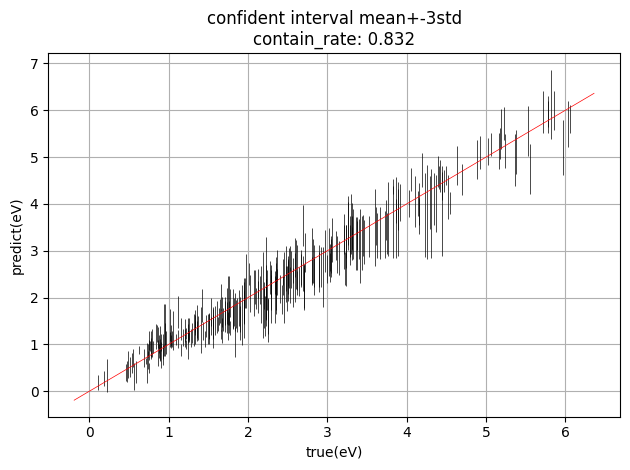

In [31]:
# 各行に対して条件を計算
true_values = all_df.iloc[:, -1]
mean_values = all_df.iloc[:, :-1].mean(axis=1)
std_values = all_df.iloc[:, :-1].std(axis=1)
lower_values = all_df.iloc[:, :-1].mean(axis=1) - all_df.iloc[:, :-1].std(axis=1) *3
upper_values = all_df.iloc[:, :-1].mean(axis=1) + all_df.iloc[:, :-1].std(axis=1) *3
# 条件に基づいてグラフを描画
plt.vlines(true_values, lower_values, upper_values, color='black', linewidth=0.5)
# 全体のカウント
all_count = len(true_values)
# 条件を満たす場合のカウント
contain_count = np.sum((lower_values <= true_values) & (true_values <= upper_values))

# 結果の出力
print(f"contain_count: {contain_count}")
print(f"all_count: {all_count}")
print(f"contain_rate: {contain_count / all_count}")

# 軸の名前を設定
plt.xlabel('true(eV)')
plt.ylabel('predict(eV)')
# y=xのグラフを描画
x = np.linspace(*plt.xlim())
plt.plot(x, x, color='red', linewidth=0.5)
# グリッドとタイトルを追加
plt.grid(True)
plt.title(f"confident interval mean+-3std\ncontain_rate: {contain_count / all_count:.3f}")
# レイアウトの調整
plt.tight_layout()
# 保存と表示
plt.savefig(f"resultplot/dropout{data_width}.png")
plt.show(block=False)
plt.close()